# 🖼️ Introduction to Multimodal Text Generation

In this notebook, we introduce the features that enable multimodal text generation in Haystack.

- We introduced the `ImageContent` dataclass, which represents the image content of a user `ChatMessage`.
- We developed some image converter components.
- The `OpenAIChatGenerator` was extended to support multimodal messages.
- The `ChatPromptBuilder` was refactored to also work with string templates, making it easier to support multimodal use cases.

In this notebook, we'll introduce all these features, show an application using **textual retrieval + multimodal generation**, and a **multimodal Agent**.

## Setup Development Environment

In [ ]:
!pip install haystack-ai gdown nest_asyncio pillow pypdfium2 python-weather

In [ ]:
import os
from getpass import getpass
from pprint import pp as print


if "OPENAI_API_KEY" not in os.environ:
  os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


## Introduction to `ImageContent`

[`ImageContent`](https://docs.haystack.deepset.ai/docs/chatmessage#types-of-content) is a new dataclass that stores the image content of a user `ChatMessage`.

It has the following attributes:
- `base64_image`: A base64 string representing the image.
- `mime_type`: The optional MIME type of the image (e.g. "image/png", "image/jpeg").
- `detail`: Optional detail level of the image (only supported by OpenAI). One of "auto", "high", or "low".
- `meta`: Optional metadata for the image.

### Creating an `ImageContent` Object

Let's start by downloading an image from the web and manually creating an `ImageContent` object. We'll see more convenient ways to do this later.

In [ ]:
! wget "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg/960px-Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg?download" -O capybara.jpg

--2025-05-14 09:29:45--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg/960px-Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg?download
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202119 (197K) [image/jpeg]
Saving to: ‘capybara.jpg’

capybara.jpg        100%[===================>] 197.38K  --.-KB/s    in 0.09s   

2025-05-14 09:29:45 (2.23 MB/s) - ‘capybara.jpg’ saved [202119/202119]



In [ ]:
from haystack.dataclasses import ImageContent, ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
import base64

with open("capybara.jpg", "rb") as fd:
  base64_image = base64.b64encode(fd.read()).decode("utf-8")

image_content = ImageContent(
    base64_image=base64_image,
    mime_type="image/jpeg",
    detail="low")

In [ ]:
image_content

ImageContent(base64_image='/9j/4QBoRXhpZgAATU0AKgAAAAgABQEaAAUAAAABAAAASgEbAAUAAAABAAAAUgEoAAMAAAABAAIAAAE7AAIAAAAFAAAAWgITAAMA...', mime_type='image/jpeg', detail='low', meta={})

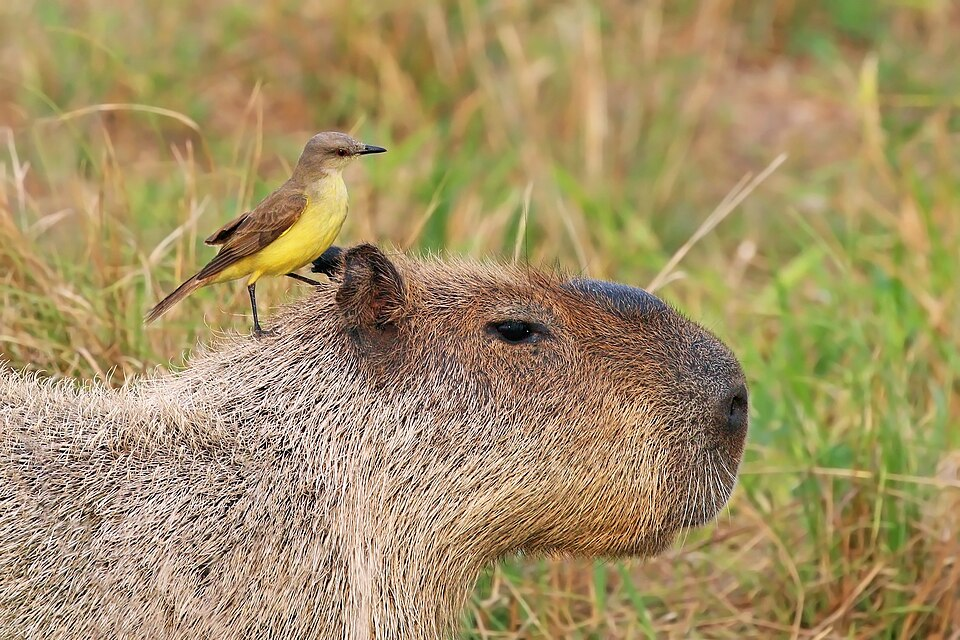

In [ ]:
image_content.show()

Nice!

To perform text generation based on this image, we need to pass it in a user message with a prompt. Let's do that.

In [ ]:
user_message = ChatMessage.from_user(content_parts=["Describe the image in short.", image_content])
llm = OpenAIChatGenerator(model="gpt-4o-mini")

In [ ]:
print(llm.run([user_message])["replies"][0].text)

('The image depicts a capybara, a large rodent, with a small bird standing on '
 'its head. The capybara has a brownish fur coat, while the bird has a yellow '
 'belly and a grayish-brown back. They are surrounded by grassy vegetation, '
 'creating a natural setting.')


### Creating an `ImageContent` Object from URL or File Path

`ImageContent` features two utility class methods:
- `from_url`: downloads an image file and wraps it in `ImageContent`
- `from_file_path`: loads an image from disk and wraps it in `ImageContent`

Using `from_url`, we can simplify the previous example. `mime_type` is automatically inferred.

In [ ]:
capybara_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg/960px-Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg?download"

image_content = ImageContent.from_url(capybara_image_url, detail="low")
image_content

ImageContent(base64_image='/9j/4QBoRXhpZgAATU0AKgAAAAgABQEaAAUAAAABAAAASgEbAAUAAAABAAAAUgEoAAMAAAABAAIAAAE7AAIAAAAFAAAAWgITAAMA...', mime_type='image/jpeg', detail='low', meta={'content_type': 'image/jpeg', 'url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg/960px-Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg?download'})

Since we downloaded the image file, we can also see `from_file_path` in action.

In this case, we will also use the `size` parameter, that resizes the image to fit within the specified dimensions while maintaining aspect ratio. This reduces file size, memory usage, and processing time, which is beneficial when working with models that have resolution constraints or when transmitting images to remote services.

In [ ]:
image_content = ImageContent.from_file_path("capybara.jpg", detail="low", size=(300, 300))
image_content

ImageContent(base64_image='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAx...', mime_type='image/jpeg', detail='low', meta={'file_path': 'capybara.jpg'})

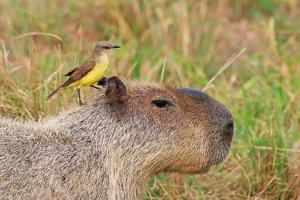

In [ ]:
image_content.show()

## Image Converters for `ImageContent`

To perform image conversion in multimodal pipelines, we also introduced two image converters:
- [`ImageFileToImageContent`](https://docs.haystack.deepset.ai/docs/imagefiletoimagecontent), which converts image files to `ImageContent` objects (similar to `from_file_path`).
- [`PDFToImageContent`](https://docs.haystack.deepset.ai/docs/pdftoimagecontent), which converts PDF files to `ImageContent` objects.

In [ ]:
from haystack.components.converters.image import ImageFileToImageContent

converter = ImageFileToImageContent(detail="low", size=(300, 300))
result = converter.run(sources=["capybara.jpg"])

In [ ]:
result["image_contents"][0]

ImageContent(base64_image='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAx...', mime_type='image/jpeg', detail='low', meta={'file_path': 'capybara.jpg'})

Let's see a more interesting example. We want our LLM to interpret a figure in this influential paper by Google: [Scaling Instruction-Finetuned Language Models](https://arxiv.org/abs/2210.11416).

In [ ]:
! wget "https://arxiv.org/pdf/2210.11416.pdf" -O flan_paper.pdf

--2025-05-14 09:31:03--  https://arxiv.org/pdf/2210.11416.pdf
Resolving arxiv.org (arxiv.org)... 151.101.67.42, 151.101.3.42, 151.101.195.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.67.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://arxiv.org/pdf/2210.11416 [following]
--2025-05-14 09:31:04--  http://arxiv.org/pdf/2210.11416
Connecting to arxiv.org (arxiv.org)|151.101.67.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557309 (1.5M) [application/pdf]
Saving to: ‘flan_paper.pdf’

flan_paper.pdf      100%[===================>]   1.48M  --.-KB/s    in 0.09s   

2025-05-14 09:31:04 (16.5 MB/s) - ‘flan_paper.pdf’ saved [1557309/1557309]



In [ ]:
from haystack.components.converters.image import PDFToImageContent

pdf_converter = PDFToImageContent()
paper_page_image = pdf_converter.run(sources=["flan_paper.pdf"], page_range="9")["image_contents"][0]
paper_page_image

ImageContent(base64_image='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAx...', mime_type='image/jpeg', detail=None, meta={'file_path': 'flan_paper.pdf', 'page_number': 9})

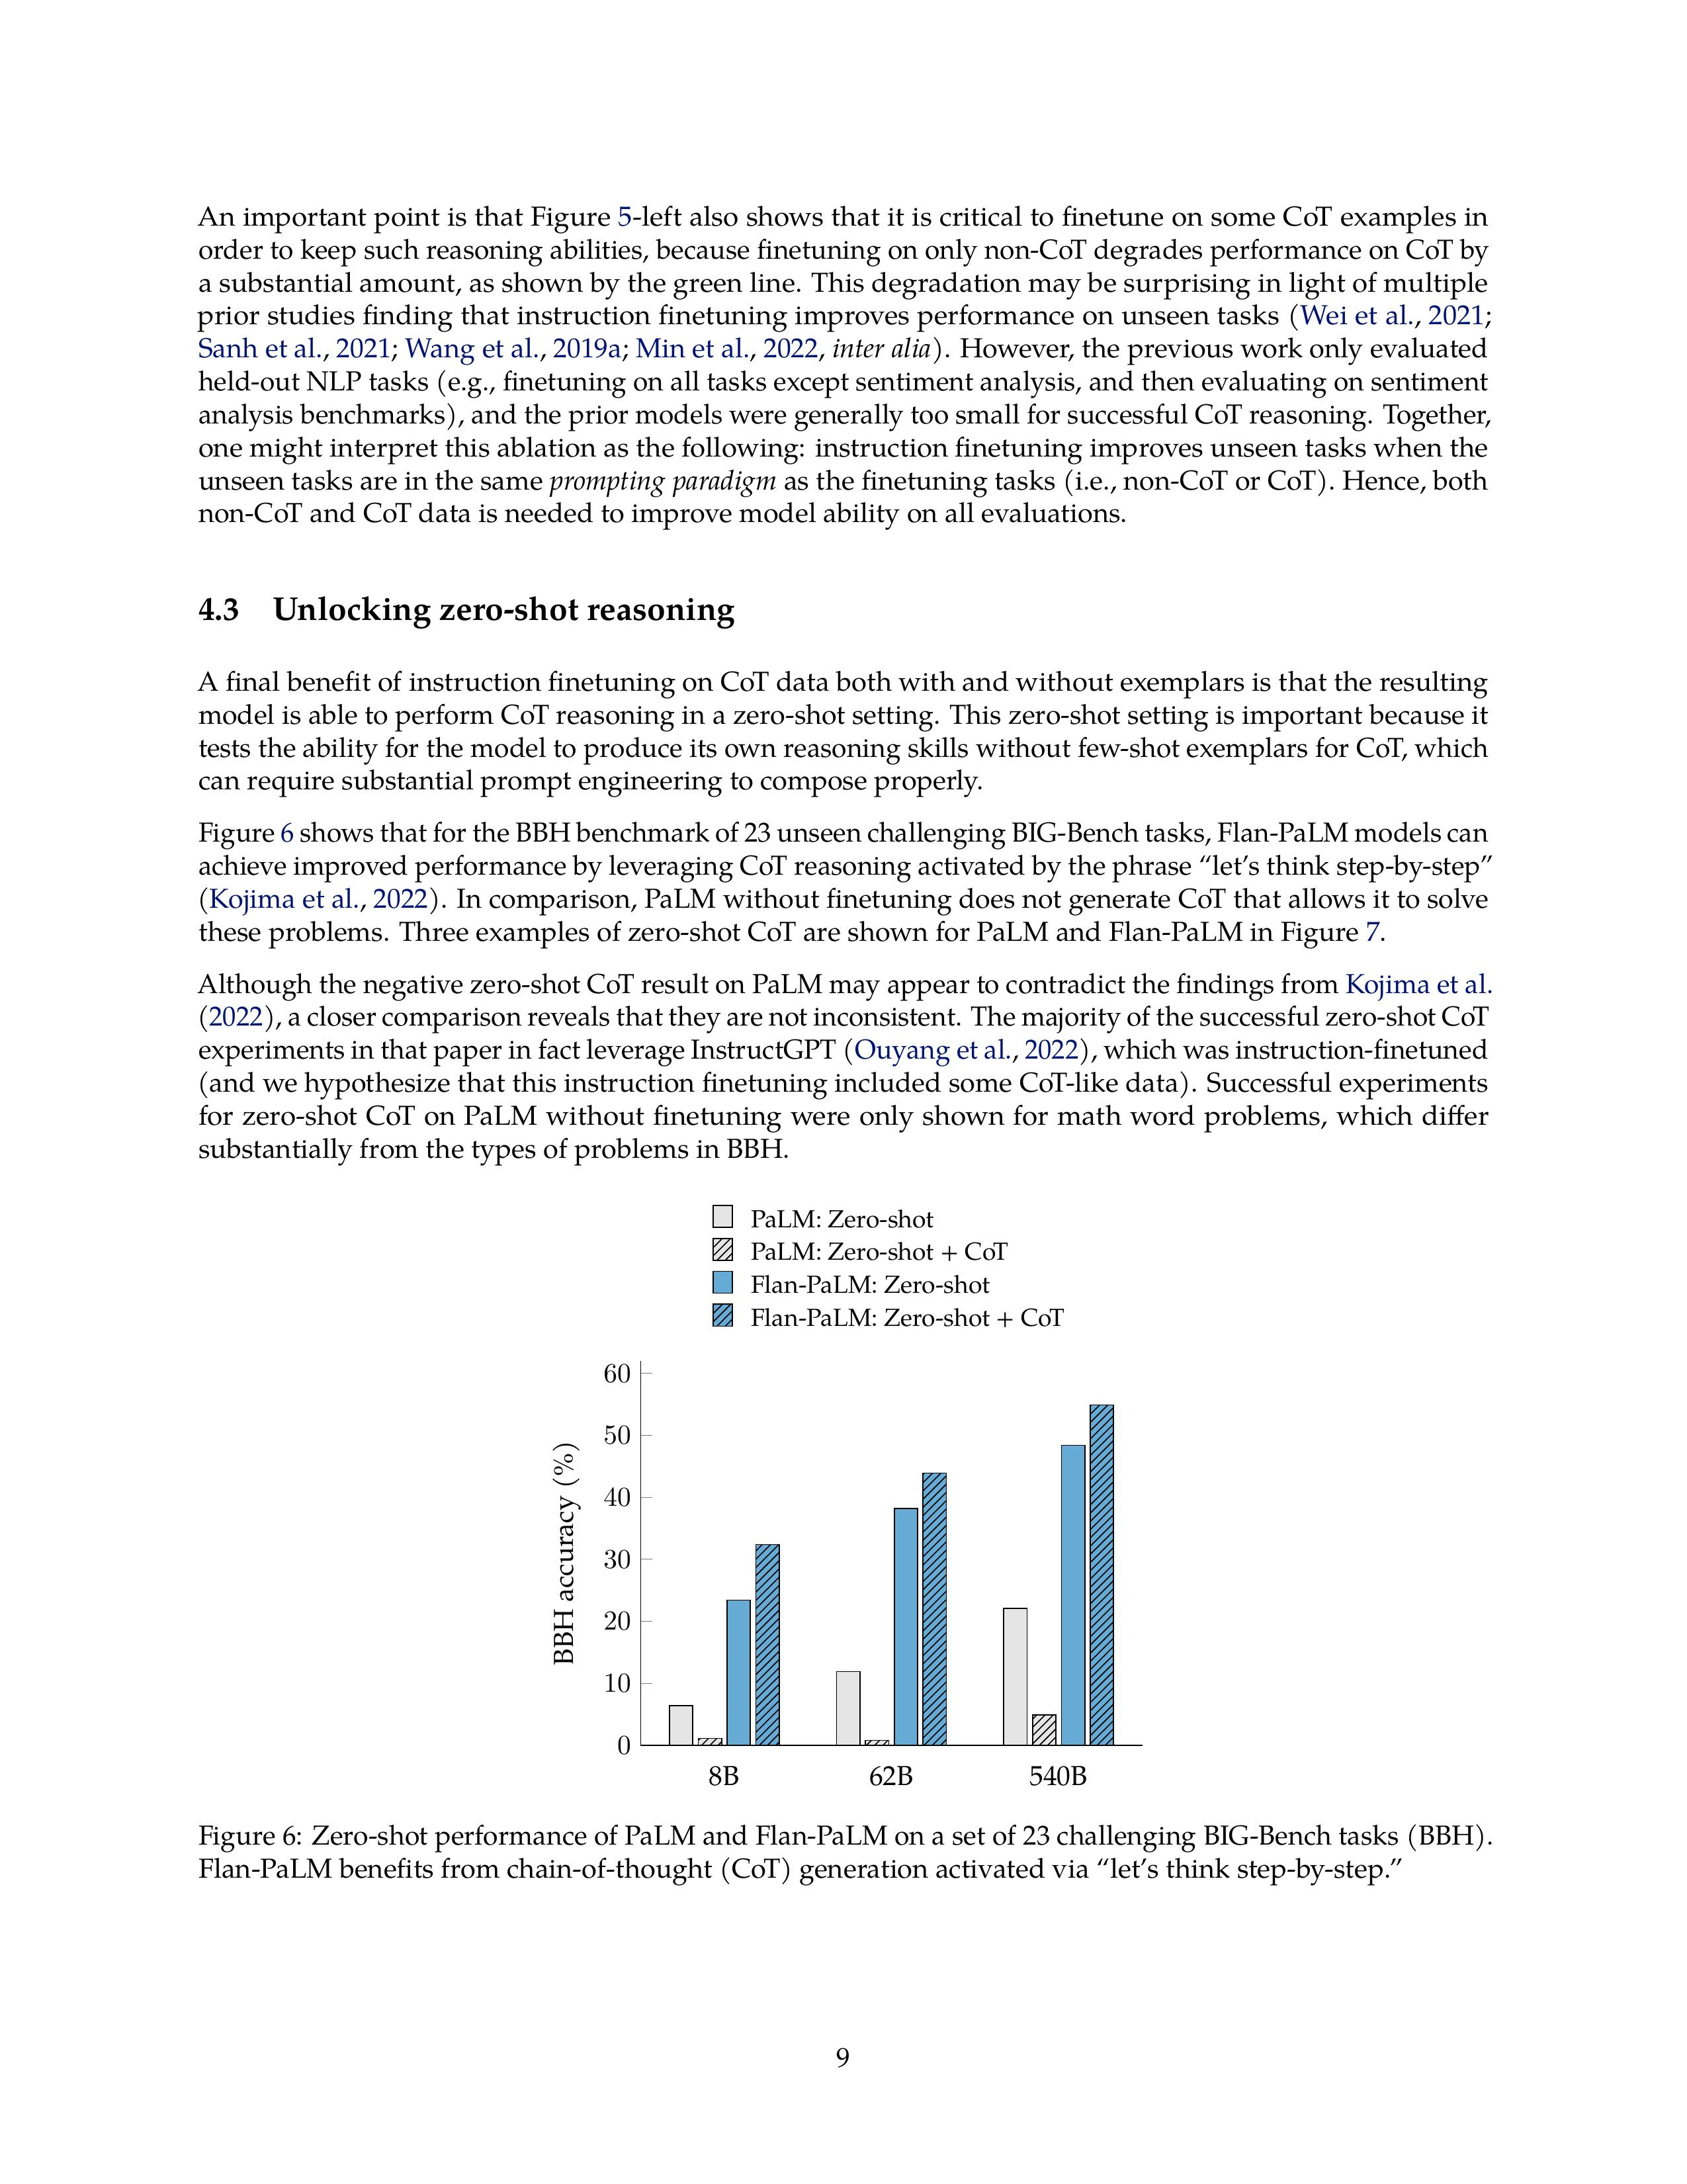

In [ ]:
paper_page_image.show()

In [ ]:
user_message = ChatMessage.from_user(content_parts=["What is the main takeaway of Figure 6? Be brief and accurate.", paper_page_image])

print(llm.run([user_message])["replies"][0].text)

('The main takeaway of Figure 6 is that Flan-PaLM demonstrates improved '
 'performance in zero-shot reasoning tasks when utilizing chain-of-thought '
 '(CoT) reasoning, as indicated by higher accuracy across different model '
 'sizes compared to PaLM without finetuning. This highlights the importance of '
 'instruction finetuning combined with CoT for enhancing reasoning '
 'capabilities in models.')


## Extended `ChatPromptBuilder` with String Templates

As we explored multimodal use cases, it became clear that the existing `ChatPromptBuilder` had some limitations. Specifically, we need a way to pass structured objects like `ImageContent` when building `ChatMessage`, and to handle a variable number of such objects.

To address this, we are introducing [support for string templates in the `ChatPromptBuilder`](https://docs.haystack.deepset.ai/docs/chatpromptbuilder#string-templates). The syntax is pretty simple, as you can see below.

In [ ]:
template = """
{% message role="system" %}
You are a {{adjective}} assistant.
{% endmessage %}

{% message role="user" %}
Compare these images:
{% for img in image_contents %}
  {{ img | templatize_part }}
{% endfor %}
{% endmessage %}
"""

Note the `| templatize_part` Jinja2 filter: this is used to indicate that the content part is a structured object, not plain text, and needs special treatment.

In [ ]:
from haystack.components.builders import ChatPromptBuilder

builder = ChatPromptBuilder(template, required_variables="*")

image_contents = [ImageContent.from_url("https://1000logos.net/wp-content/uploads/2017/02/Apple-Logosu.png", detail="low"),
                  ImageContent.from_url("https://upload.wikimedia.org/wikipedia/commons/2/26/Pink_Lady_Apple_%284107712628%29.jpg", detail="low")]

messages = builder.run(image_contents=image_contents, adjective="joking")["prompt"]
print(messages)

[ChatMessage(_role=<ChatRole.SYSTEM: 'system'>,
             _content=[TextContent(text='You are a joking assistant.')],
             _name=None,
             _meta={}),
 ChatMessage(_role=<ChatRole.USER: 'user'>,
             _content=[TextContent(text='Compare these images:'),
                       ImageContent(base64_image='iVBORw0KGgoAAAANSUhEUgAADwAAAAhwAgMAAADt0CPhAAAADFBMVEVHcEwAAADe3t58fHxUHjQgAAAAAXRSTlMAQObYZgAAIABJ...', mime_type='image/png', detail='low', meta={'content_type': 'image/png', 'url': 'https://1000logos.net/wp-content/uploads/2017/02/Apple-Logosu.png'}),
                       ImageContent(base64_image='/9j/4AAQSkZJRgABAQEA8ADwAAD/7SnQUGhvdG9zaG9wIDMuMAA4QklNA+0AAAAAABAA8AAAAAEAAQDwAAAAAQABOEJJTQQMAAAA...', mime_type='image/jpeg', detail='low', meta={'content_type': 'image/jpeg', 'url': 'https://upload.wikimedia.org/wikipedia/commons/2/26/Pink_Lady_Apple_%284107712628%29.jpg'})],
             _name=None,
             _meta={})]


In [ ]:
print(llm.run(messages)["replies"][0].text)

("Sure! Let's dive into these fruity comparisons! \n"
 '\n'
 "1. **Apple Logo**: This is a stylized logo of an apple. It's simple, iconic, "
 "and represents a well-known tech company. It's all about design and branding "
 '– who knew a fruit could be so influential in the tech world?\n'
 '\n'
 "2. **Real Apple**: This is an actual apple, the kind you can bite into! It's "
 'delicious, nutritious, and makes a great snack or pie ingredient. Plus, it '
 "doesn't need charging!\n"
 '\n'
 'In short, one is a tech icon, and the other is a snackable delight. Both are '
 'essential in their own realms! 🍏🍎')


## Textual Retrieval and Multimodal Generation

Let's see a more advanced example.

In this case, we have a collection of images from papers about Language Models.

Our goal is to build a system that can:
1. Retrieve the most relevant image from this collection based on a user's textual question.
2. Use this image, along with the original question, to have an LLM generate an answer.

We start by downloading the images.

In [ ]:
import gdown

url = "https://drive.google.com/drive/folders/1KLMow1NPq6GIuoNfOmUbjUmAcwFNmsCc"

gdown.download_folder(url, quiet=True, output=".")

['./arxiv/direct_preference_optimization.png',
 './arxiv/large_language_diffusion_models.png',
 './arxiv/lora_vs_full_fine_tuning.png',
 './arxiv/magpie.png',
 './arxiv/online_ai_feedback.png',
 './arxiv/reverse_thinking_llms.png',
 './arxiv/scaling_laws_for_precision.png',
 './arxiv/spectrum.png',
 './arxiv/textgrad.png',
 './arxiv/tulu_3.png',
 './map.png']

We create an `InMemoryDocumentStore` and write a Document there for each image: the content is a textual description of the image; the image path is stored in `meta`.

The content of the Documents here is minimal. You can think of more sophisticated ways to create a representive content: perform OCR or use a Vision Language Model.
We'll explore this direction in the future.

In [ ]:
import glob
from haystack.dataclasses import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore

docs = []

for image_path in glob.glob("arxiv/*.png"):
    text = "image from '" + image_path.split("/")[-1].replace(".png", "").replace("_", " ") + "' paper"
    docs.append(Document(content=text, meta={"image_path": image_path}))

document_store = InMemoryDocumentStore()
document_store.write_documents(docs)

10

We perform text-based retrieval (using BM25) to get the most relevant Document. Then an `ImageContent` object is created using the image file path. Finally, the `ImageContent` is passed to the LLM with the user question.

In [ ]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ImageContent, ChatMessage

retriever = InMemoryBM25Retriever(document_store=document_store)
llm = OpenAIChatGenerator(model="gpt-4o-mini")

def retrieve_and_generate(question):
  doc = retriever.run(query=question, top_k=1)["documents"][0]
  image_content = ImageContent.from_file_path(doc.meta["image_path"], detail="auto")
  image_content.show()

  message = ChatMessage.from_user(content_parts=[question, image_content])
  response = llm.run(messages=[message])["replies"][0].text
  print(response)

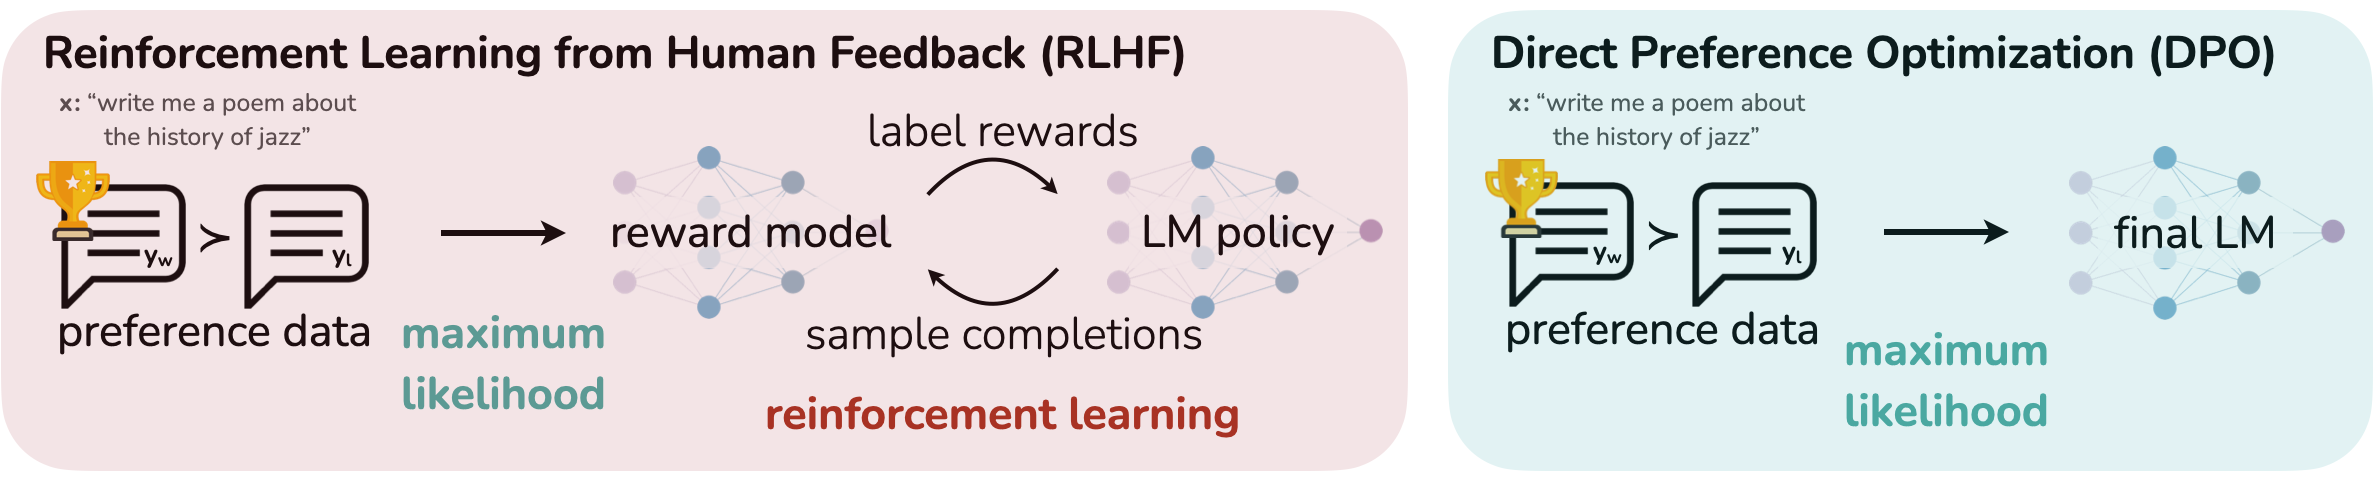

('The image compares two methods in machine learning: Reinforcement Learning '
 'from Human Feedback (RLHF) and Direct Preference Optimization (DPO).\n'
 '\n'
 '### Left Side: RLHF\n'
 '- **Process**: \n'
 '  - Input example: "write me a poem about the history of jazz."\n'
 '  - Preference data shown as two different responses (y₁ and y₂).\n'
 '- **Components**:\n'
 '  - It includes a "reward model" that labels the quality of outputs and '
 'involves a reinforcement learning process.\n'
 '  - The goal is to derive an LM policy through sampling that improves over '
 'time.\n'
 '- **Key Terms**: "preference data," "maximum likelihood," "reinforcement '
 'learning."\n'
 '\n'
 '### Right Side: DPO\n'
 '- **Process**:\n'
 '  - Similar input as on the left.\n'
 '  - Preference data involves determining which response (y₁ or y₂) is '
 'preferred without a reward model.\n'
 '- **Components**:\n'
 '  - Focuses directly on optimizing preferences to produce a final language '
 'model.\n'
 '- **Ke

In [ ]:
retrieve_and_generate("Describe the image of the Direct Preference Optimization paper")

Here are some other example questions to test:

In [ ]:
examples = [
    "Describe the image of the LoRA vs Full Fine-tuning paper",
    "Describe the image of the Online AI Feedback paper",
    "Describe the image of the Spectrum paper",
    "Describe the image of the Textgrad paper",
    "Describe the image of the Tulu 3 paper",
]

## Multimodal Agent

Let's combine multimodal messages with the [Agent](https://docs.haystack.deepset.ai/docs/agents) component. 

We start with creating a weather [Tool](https://docs.haystack.deepset.ai/docs/tool), based on the [python-weather library](https://python-weather.readthedocs.io/). The library is asynchronous while the Tool abstraction expects a synchronous invocation method, so we make some adaptations.

> Learn more about creating agents in [Tutorial: Build a Tool-Calling Agent](https://haystack.deepset.ai/tutorials/43_building_a_tool_calling_agent)

In [ ]:
import asyncio
from typing import Annotated

from haystack.tools import tool
from haystack.components.agents import Agent
from haystack.components.generators.chat import OpenAIChatGenerator

from haystack.dataclasses import ChatMessage, ImageContent
import python_weather

# only needed in Jupyter notebooks where there is an event loop running
import nest_asyncio
nest_asyncio.apply()


@tool
def get_weather(location: Annotated[str, "The location to get the weather for"]) -> dict:
    """A function to get the weather for a given location"""
    async def _fetch_weather():
        async with python_weather.Client(unit=python_weather.METRIC) as client:
            weather = await client.get(location)
            return {
                "description": weather.description,
                "temperature": weather.temperature,
                "humidity": weather.humidity,
                "precipitation": weather.precipitation,
                "wind_speed": weather.wind_speed,
                "wind_direction": weather.wind_direction
            }

    return asyncio.run(_fetch_weather())

Let's test our Tool by invoking it with the required parameter:

In [ ]:
get_weather.invoke(location="New York")

{'description': 'Heavy rain, fog',
 'temperature': 14,
 'humidity': 93,
 'precipitation': 0.0,
 'wind_speed': 24,
 'wind_direction': WindDirection.EAST_SOUTHEAST}

We can now define an Agent, provide it with the weather Tool and see if it can find the weather based on a geographical map.

In [ ]:
generator = OpenAIChatGenerator(model="gpt-4o-mini")
agent = Agent(chat_generator=generator, tools=[get_weather])

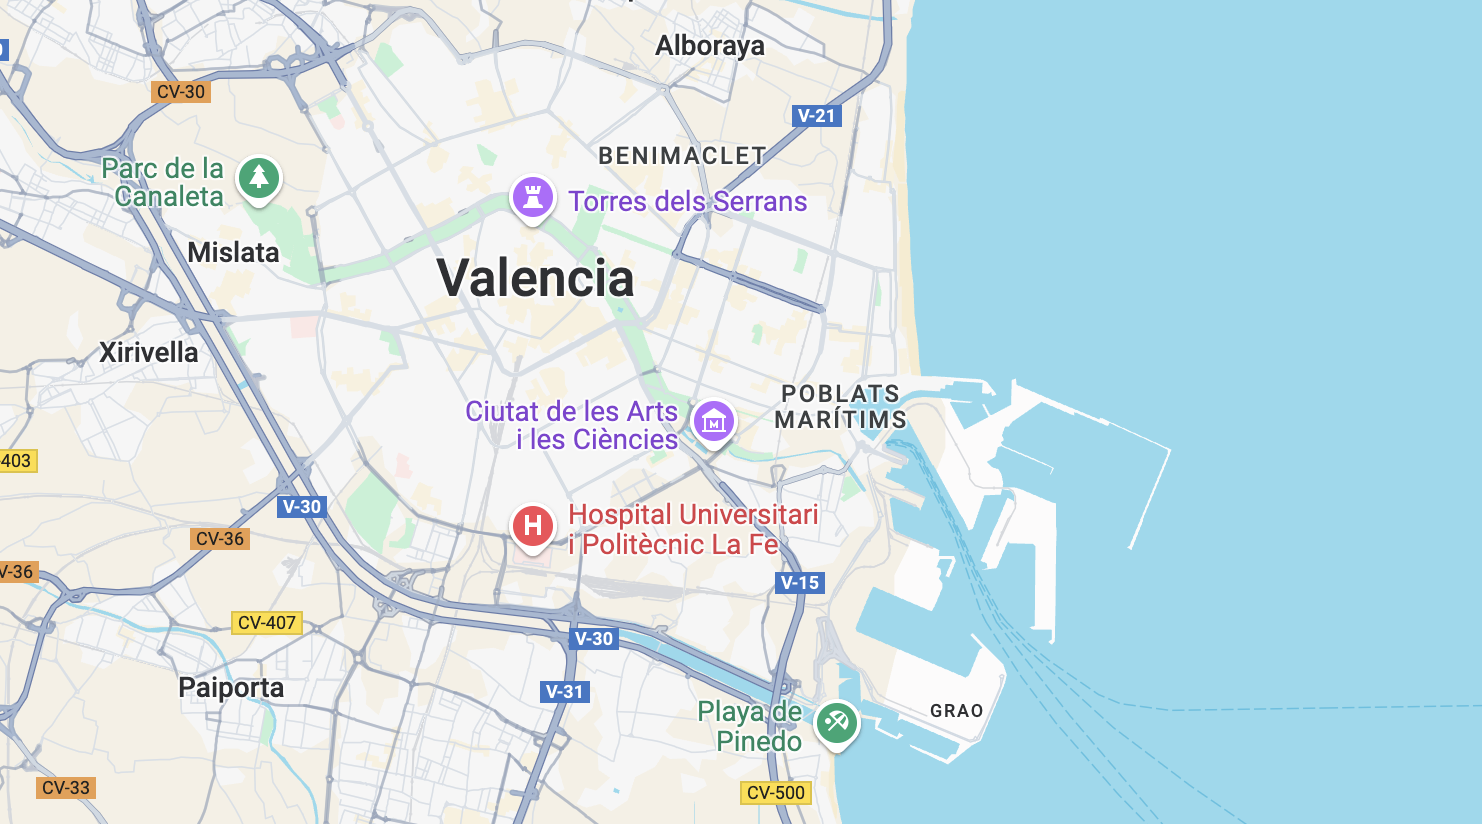

In [ ]:
map_image = ImageContent.from_file_path("map.png")
map_image.show()

In [ ]:
content_parts = ["What is the weather in the area of the map?", map_image]
messages = agent.run([ChatMessage.from_user(content_parts=content_parts)])["messages"]

print(messages[-1].text)

('The weather in Valencia, Spain is currently overcast with a temperature of '
 '21°C. The humidity is at 64%, and there is no precipitation. Winds are '
 'coming from the east-northeast at a speed of 25 km/h.')


## What's next?

We also support image capabilities across a variety of LLM providers, including Amazon Bedrock, Google, Mistral, Ollama, and more.

To learn how to build more advanced multimodal pipelines, with different file formats and multimodal embedding models, check out the [Creating Vision+Text RAG Pipelines tutorial](https://haystack.deepset.ai/tutorials/46_multimodal_rag).

(*Notebook by [Stefano Fiorucci](https://github.com/anakin87)*)